<a href="https://colab.research.google.com/github/VimalKandrical/dl_sound_class/blob/Christian/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification of Environmental Sound
**Autoren:**<br> Vimal Kandrical, Christian von Rotz

**Daten:**<br>[Urbansound8k](https://www.kaggle.com/chrisfilo/urbansound8k) 

# Einleitung

Im Rahmen des Moduls Deep Learning im CAS Machine Intelligence werden in diesem Projekt Tonaufnahmen von Umgebungsgeräuschen analysiert und mittels Deep Learning klassifiziert.  

##Beschreibung der Daten (kaggle.com)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided.

**Audiofiles:**

8732 audio files of urban sounds (see description above) in WAV format. The sampling rate, bit depth, and number of channels are the same as those of the original file uploaded to Freesound (and hence may vary from file to file).

**Metadaten:**
*   slicefilename:<br>
    The name of the audio file. The name takes the following format:<br><br> [fsID]-4s[classID]-[occurrenceID]-[sliceID].wav<br><br>
    
    [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
   <br> [classID] = a numeric identifier of the sound class (see description of classID below for further details)
   <br> [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
   <br> [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence
*   fsID:<br>
The Freesound ID of the recording from which this excerpt (slice) is taken
*   start:<br>
The start time of the slice in the original Freesound recording
*   end:<br>
The end time of slice in the original Freesound recording
*   salience:<br>
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
*   fold:<br>
The fold number (1-10) to which this file has been allocated.
*   classID:<br>
A numeric identifier of the sound class:
    0 = airconditioner 1 = carhorn
    2 = childrenplaying 3 = dogbark
    4 = drilling
    5 = engineidling 6 = gunshot
    7 = jackhammer
    8 = siren
    9 = street_music
*   class:<br>
 The class name: airconditioner, carhorn, childrenplaying, dogbark, drilling, engineidling, gunshot, jackhammer,
    siren, street_music.

**Bemerkungen:**<br>
Auf kaggle wird explizit darauf hingewiesen, dass man die Daten nicht noch einmal mischen soll, sondern die vordefinierten 10 folds benützen soll. Nur so kann das erzielte Resultat mit anderen Resultaten verglichen. Zudem soll 10-fold cross validation angewendet werden, da die einzelnen folds nicht gleich schwer sind. Das Endresultat ist die durchschnittliche accuracy. 

# Daten laden

*Dieser Teil muss nur einmal ausgeführt werden, damit die Daten in Colab sind.*

Google Colab benötigt Zugriff auf Kaggle via API. Der API Token muss unter content abliegen.

In [2]:
from google.colab import drive
import os
os.chdir("/content")
os.listdir()

['.config', 'sample_data']

Zugriffsrechte anpassen und File downloaden

In [4]:
!mkdir -p ~/.kaggle
!cp "/content/kaggle.json" ~/.kaggle/
!chmod 600 "/content/kaggle.json"
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.60G/5.61G [01:20<00:00, 27.3MB/s]
100% 5.61G/5.61G [01:20<00:00, 74.7MB/s]


Zipfile entpacken

In [5]:
os.chdir("/content")
!unzip urbansound8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: fold4/154758-5-0-0.wav  
  inflating: fold4/154758-5-0-1.wav  
  inflating: fold4/154758-5-0-10.wav  
  inflating: fold4/154758-5-0-11.wav  
  inflating: fold4/154758-5-0-12.wav  
  inflating: fold4/154758-5-0-13.wav  
  inflating: fold4/154758-5-0-14.wav  
  inflating: fold4/154758-5-0-15.wav  
  inflating: fold4/154758-5-0-16.wav  
  inflating: fold4/154758-5-0-17.wav  
  inflating: fold4/154758-5-0-18.wav  
  inflating: fold4/154758-5-0-19.wav  
  inflating: fold4/154758-5-0-2.wav  
  inflating: fold4/154758-5-0-20.wav  
  inflating: fold4/154758-5-0-21.wav  
  inflating: fold4/154758-5-0-3.wav  
  inflating: fold4/154758-5-0-4.wav  
  inflating: fold4/154758-5-0-5.wav  
  inflating: fold4/154758-5-0-6.wav  
  inflating: fold4/154758-5-0-7.wav  
  inflating: fold4/154758-5-0-8.wav  
  inflating: fold4/154758-5-0-9.wav  
  inflating: fold4/155320-3-0-0.wav  
  inflating: fold4/156362-4-0-0.wav  
  inflating: fold4/156362

# Voranalyse

Bevor die Audiofiles genutzt werden können, muss ihr Aufbau verstanden werden. Diese Informationen stehen ganz am Anfang des WAV Files im sogenannten Header (44 Bytes lang). Folgende Informationen sind relevant:

Information  | Position
  ------------- | -------------
  Anzahl Channels (mono/stereo)  | 23-24
  Sample rate  | 25-28
Bits pro Sample | 35-36

(Details zum Aufbau eines WAV (RIFF) Files können [hier](http://www.topherlee.com/software/pcm-tut-wavformat.html) nachgelesen werden.)

Hier ein Beispiel:

In [6]:
import struct
import os


def readheader(filename):
  with open(filename, "rb") as wavfile:
    header = wavfile.read(44)
    channels = struct.unpack("<H", header[22:24])[0]
    samplerate = struct.unpack("<I", header[24:28])[0]
    bitsprosample = struct.unpack("<H", header[34:36])[0]
  return (channels, samplerate, bitsprosample)

beispiel = readheader("/content/fold1/101415-3-0-2.wav")
print("Anzahl Channels: ", beispiel[0])
print("Sample rate: ", beispiel[1])
print("Bits pro Sample: ", beispiel[2])

Anzahl Channels:  1
Sample rate:  48000
Bits pro Sample:  16


Zuest lesen wir nun die Klassenzugehörigkeit jedes Audiofiles

In [15]:
import pandas as pd

pd.options.display.max_columns = 10

metadaten = pd.read_csv("/content/UrbanSound8K.csv")
# Anpassung des Header des Dataframes, da class ein reservierter Begriff ist
metadaten = metadaten.rename({'class': 'class_name'}, axis='columns')
print('Metadaten header', '\n')
print(metadaten.head()) 
print('\n', 'Datentypen der einzelnen Variablen', '\n')
print(metadaten.dtypes) #-> passt soweit
print('\n', 'Klassenzugehörigkeit', '\n')
print(metadaten.class_name.value_counts())
print('\n')

Metadaten header 

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

         class_name  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

 Datentypen der einzelnen Variablen 

slice_file_name     object
fsID                 int64
start              float64
end                float64
salience             int64
fold                 int64
classID              int64
class_name          object
dtype: object

 Klassenzugehörigkeit 

street_music        1000
engine_idling       1000
air_conditioner     1000
children_playing    100

Der Datensatz hat keine regelmässige Verteilung auf die Klassen! 

Wir lesen nun analog oben für jedes Audiofiles die Charakteristik und halten diese in einem Dataframe fest.

In [16]:
informationen = []

for i, r in metadaten.iterrows():
  audiofile = os.path.join(os.path.abspath("/content/"),"fold"+str(r["fold"])+"/",str(r["slice_file_name"]))
  informationen.append(readheader(audiofile))

aufbau = pd.DataFrame(informationen, columns=['anz_channels','samplerate','bits_pro_sample'])
print(aufbau["anz_channels"].value_counts())
print(aufbau["samplerate"].value_counts())
print(aufbau["bits_pro_sample"].value_counts())

2    7993
1     739
Name: anz_channels, dtype: int64
44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: samplerate, dtype: int64
16    5758
24    2753
32     169
8       43
4        9
Name: bits_pro_sample, dtype: int64


Es lässt sich festhalten, dass die Audiofiles bzgl. Anzahl Channels (Mono/Stereo), Samplerate und Bits pro Sample variieren.

# Vorbereitung der Daten aufgrund der Voranalyse

Wir haben festgestellt, dass die Datensätze unterschiedliche Ausprägungen und den Daten haben und bezüglich der Datenkonsistenz vorbereitet/angepasst werden müssen. Dazu verwenden wir die <b> Librosa load()</b> Funktion.
<ul>
<li>Anzahl channels: werden auf 1 reduziert</li>
<li>Samplerate: konvertiert alle Samples auf 22.050 KHz</li>
<li>Bits pro sample: wird auf einen range von -1 und 1 normalisiert</li>
</ul>

Anhand eines Beispiel zeigen wir diese Anpassungen auf

Anzeige der Kanäle 



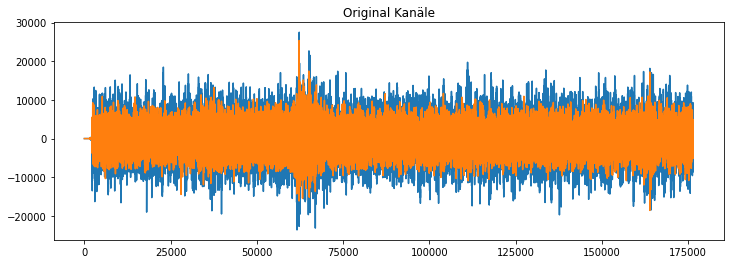

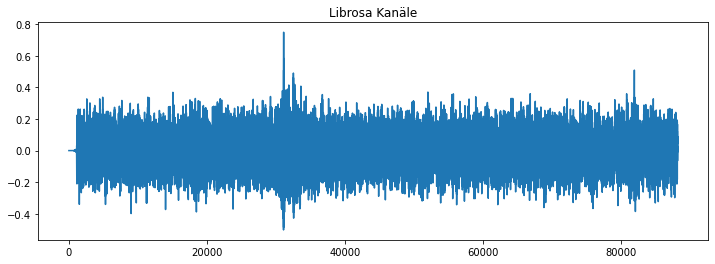


 Anzeige der Samplerate
Original Hz:  44100
Librosa Hz:  22050

 Anzeige der Bits pro sample
Original audio file min~max range:  -23628 to 27507
Librosa audio file min~max range:  -0.50266445 to 0.74983937


In [29]:
import librosa
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import numpy as np

# ein Beispielfilename
beispiel_dateiname = "/content/fold5/100852-0-0-0.wav"
librosa_audio, librosa_sample_rate = librosa.load(beispiel_dateiname)
scipy_sample_rate, scipy_audio = wav.read(beispiel_dateiname)

# Anzahl Kanäle
print('Anzeige der Kanäle', '\n')
plt.figure(figsize = (12, 4))
plt.title('Original Kanäle')
plt.plot(scipy_audio)

plt.figure(figsize = (12, 4))
plt.title('Librosa Kanäle')
plt.plot(librosa_audio)
plt.show()

# Sample rate
print('\n', 'Anzeige der Samplerate')
print('Original Hz: ', scipy_sample_rate)
print('Librosa Hz: ', librosa_sample_rate)

# Bits pro sample
print('\n', 'Anzeige der Bits pro sample')
print('Original audio file min~max range: ', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range: ', np.min(librosa_audio), 'to', np.max(librosa_audio))

# Feature extraction

Wir extrahieren die <b>Mel-Frequency Cepstral Coefficients (MFCC)</b> der jeweiligen Audiofiles zusammen mit deren Klassenzugehörigkeit. Dank diesem Feature können wir sowohl die Frequenz als auch die zeitliche Charakteristik eines Files erkennen.

In [30]:
mfccs = librosa.feature.mfcc(y = librosa_audio, sr = librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)

(40, 173)


Für ein einzelnes Audiofile werden also 400 MFCCs über 173 frames erstellt!

Wir extrahieren nun für alle Audiofiles die MFCC

In [0]:
def extract_features(files_name):

  try:
    audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
    mfccsscaled = np.mean(mfccs.T, axis = 0)

  except Exception as e:
    print('Error encountered while parsing audiofile: ', file)
    return None

  return mfccsscaled

